#****Proyecto 2 - Security Data Science****
# ****Modelos de Deteccion de Fraude Bancario****

## **Nombre**: Pedro Arriola
## **Carnet**: 20188

Este trabajo práctico tiene como objetivo investigar la viabilidad del entrenamiento incremental en modelos de aprendizaje automático y profundo, utilizando como estudio de caso un dataset de transacciones de tarjeta de crédito clasificadas en normales y fraudulentas. Los modelos a investigar den incluir 2 de los siguientes algoritmos: Redes Neuronales Artificiales (ANN), LightGBM, XGBoost, Random Forest y Máquinas de Vectores de Soporte (SVM).


### Carga del Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 27 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   trans_date_trans_time         object 
 1   cc_num                        int64  
 2   merchant                      object 
 3   category                      object 
 4   amt                           float64
 5   first                         object 
 6   last                          object 
 7   gender                        object 
 8   street                        object 
 9   city                          object 
 10  state                         object 
 11  zip                           int64  
 12  lat                           float64
 13  long                          float64
 14  city_pop                      int64  
 15  job                           object 
 16  dob                           object 
 17  trans_num                     object 
 18  unix_time             

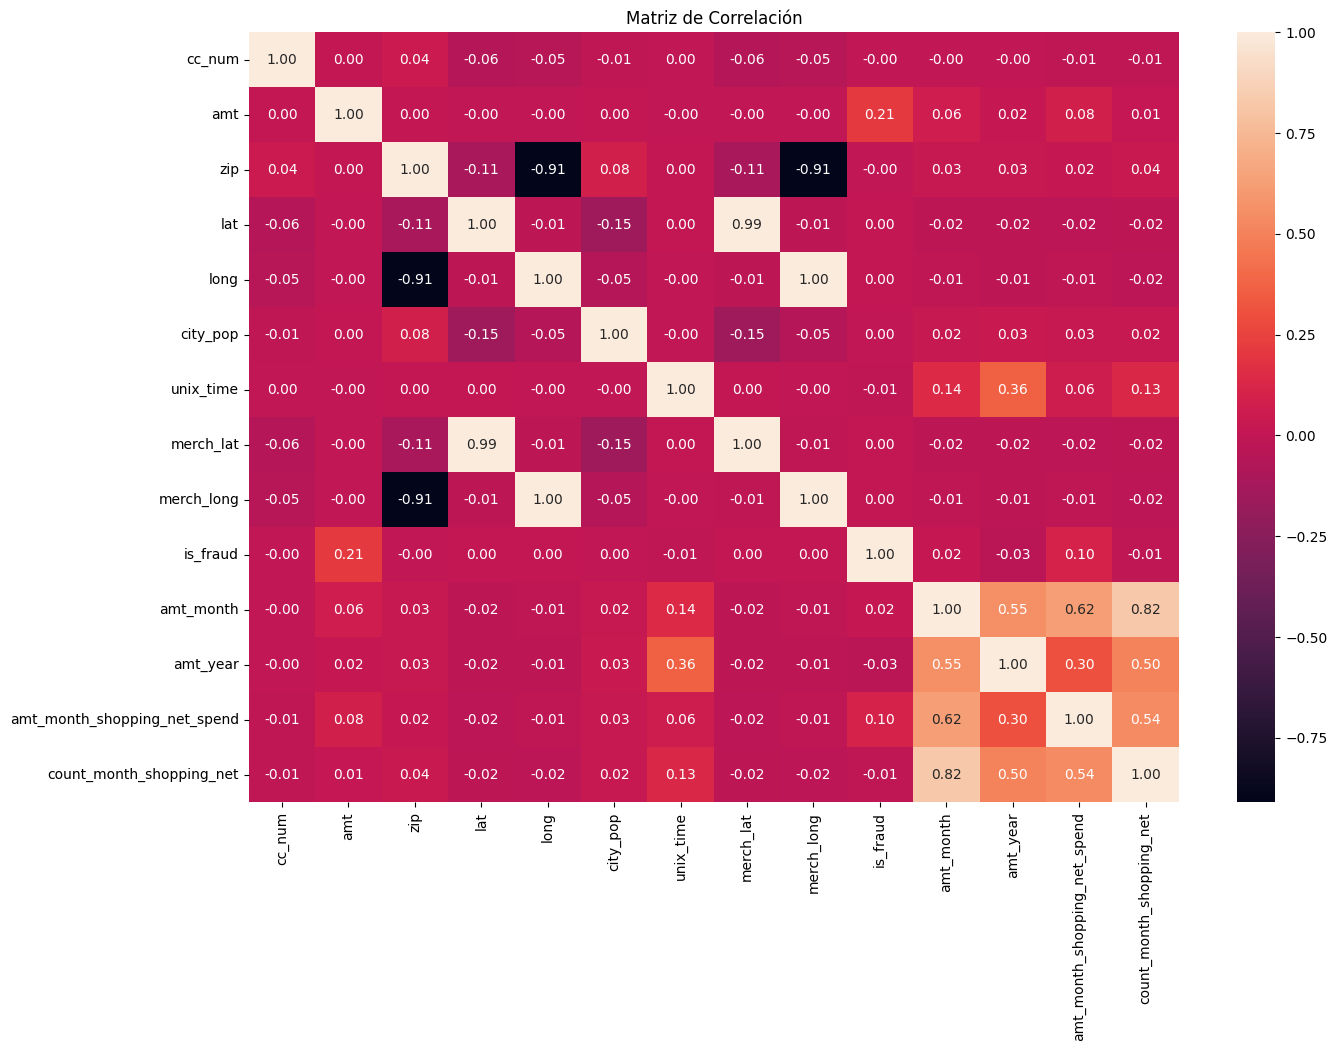

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
file_path = '/content/drive/MyDrive/fraud/fraud_feature_engineering_example.csv'
df = pd.read_csv(file_path)

# Exploración inicial del dataset
df.head()
df.info()
df.describe()

# Verificar valores nulos
df.isnull().sum()

# Convertir 'trans_date_trans_time' a datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Seleccionar solo columnas numéricas para la matriz de correlación
numerical_columns = df.select_dtypes(include=[float, int]).columns
corr_matrix = df[numerical_columns].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

### Ingenieria de Variables

In [ ]:
# Crear variables temporales
df['Transaction_hour'] = df['trans_date_trans_time'].dt.hour
df['Transaction_day'] = df['trans_date_trans_time'].dt.day
df['Transaction_month'] = df['trans_date_trans_time'].dt.month
df['Transaction_year'] = df['trans_date_trans_time'].dt.year
df['Transaction_day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['Transaction_weekend'] = df['Transaction_day_of_week'].isin([5, 6]).astype(int)
df['Transaction_quarter'] = df['trans_date_trans_time'].dt.quarter

# Crear variables de días desde la última y primera transacción del mismo cliente
df = df.sort_values(by=['cc_num', 'trans_date_trans_time'])
df['Days_since_last_transaction'] = df.groupby('cc_num')['trans_date_trans_time'].diff().dt.days
df['Days_since_last_transaction'].fillna(0, inplace=True)  # Rellenar NaN con 0 para la primera transacción
df['Days_since_first_transaction'] = df['trans_date_trans_time'] - df.groupby('cc_num')['trans_date_trans_time'].transform('min')
df['Days_since_first_transaction'] = df['Days_since_first_transaction'].dt.days

# Verificación de las nuevas características
df_temporal_features = df[['Transaction_hour', 'Transaction_day', 'Transaction_month', 'Transaction_day_of_week',
                           'Transaction_weekend', 'Transaction_quarter', 'Days_since_last_transaction', 'Days_since_first_transaction']]
df_temporal_features.head()

,Transaction_hour,Transaction_day,Transaction_month,Transaction_day_of_week,Transaction_weekend,Transaction_quarter,Days_since_last_transaction,Days_since_first_transaction
1017,12,1,1,1,0,1,0.0,0
2724,8,2,1,2,0,1,0.0,0
2726,8,2,1,2,0,1,0.0,0
2882,12,2,1,2,0,1,0.0,0
2907,13,2,1,2,0,1,0.0,1


In [ ]:
# Creación de variables basadas en el monto
df['Transaction_amount_log'] = np.log1p(df['amt'])
df['Transaction_amount_square'] = df['amt'] ** 2
df['Transaction_amount_sqrt'] = np.sqrt(df['amt'])
df['Transaction_amount_cubed'] = df['amt'] ** 3

# Variables de estadísticas por cliente
df['Avg_transaction_amount'] = df.groupby('cc_num')['amt'].transform('mean')
df['Std_transaction_amount'] = df.groupby('cc_num')['amt'].transform('std').fillna(0)
df['Min_transaction_amount'] = df.groupby('cc_num')['amt'].transform('min')
df['Max_transaction_amount'] = df.groupby('cc_num')['amt'].transform('max')

# Verificación de las nuevas características
df_monto_features = df[['Transaction_amount_log', 'Transaction_amount_square', 'Transaction_amount_sqrt',
                        'Transaction_amount_cubed', 'Avg_transaction_amount', 'Std_transaction_amount',
                        'Min_transaction_amount', 'Max_transaction_amount']]
df_monto_features.head()

,Transaction_amount_log,Transaction_amount_square,Transaction_amount_sqrt,Transaction_amount_cubed,Avg_transaction_amount,Std_transaction_amount,Min_transaction_amount,Max_transaction_amount
1017,2.112635,52.8529,2.696294,384.240583,59.257796,142.869746,1.02,3437.46
2724,3.987872,2802.6436,7.275988,148371.952184,59.257796,142.869746,1.02,3437.46
2726,4.419804,6737.1264,9.059801,552983.334912,59.257796,142.869746,1.02,3437.46
2882,3.577669,1210.3441,5.898305,42107.871239,59.257796,142.869746,1.02,3437.46
2907,3.338613,738.7524,5.213444,20079.290232,59.257796,142.869746,1.02,3437.46


In [ ]:
# Variables de frecuencia
df['Num_transactions_last_day'] = df.groupby('cc_num')['trans_date_trans_time'].transform(lambda x: (x.diff().dt.days.fillna(0) == 0).cumsum())
df['Num_transactions_last_week'] = df.groupby('cc_num')['trans_date_trans_time'].transform(lambda x: (x.diff().dt.days.fillna(0) < 7).cumsum())
df['Num_transactions_last_month'] = df.groupby('cc_num')['trans_date_trans_time'].transform(lambda x: (x.diff().dt.days.fillna(0) < 30).cumsum())
df['Avg_transactions_per_day'] = df.groupby(['cc_num', df['trans_date_trans_time'].dt.date])['trans_date_trans_time'].transform('count') / df.groupby('cc_num')['trans_date_trans_time'].transform(lambda x: x.dt.date.nunique())

# Verificación de las nuevas características
df_frecuencia_features = df[['Num_transactions_last_day', 'Num_transactions_last_week', 'Num_transactions_last_month', 'Avg_transactions_per_day']]
df_frecuencia_features.head()

,Num_transactions_last_day,Num_transactions_last_week,Num_transactions_last_month,Avg_transactions_per_day
1017,1,1,1,0.001464
2724,2,2,2,0.005857
2726,3,3,3,0.005857
2882,4,4,4,0.005857
2907,5,5,5,0.005857


In [ ]:
# Función para calcular la distancia euclidiana
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radio de la Tierra en kilómetros
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Calcular la distancia entre el hogar del cliente y el comercio
df['Distance_home_merch'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

# Calcular la distancia entre el comercio de la última transacción y el comercio actual
df = df.sort_values(by=['cc_num', 'trans_date_trans_time'])
df['Distance_last_trans_merch'] = df.groupby('cc_num').apply(lambda x: haversine(x['merch_lat'], x['merch_long'], x['merch_lat'].shift(), x['merch_long'].shift())).reset_index(level=0, drop=True)
df['Distance_last_trans_merch'].fillna(0, inplace=True)

# Calcular la distancia promedio y máxima entre el hogar del cliente y los comercios
df['Avg_distance_home_merch'] = df.groupby('cc_num')['Distance_home_merch'].transform('mean')
df['Max_distance_home_merch'] = df.groupby('cc_num')['Distance_home_merch'].transform('max')

# Verificación de las nuevas características
df_geograficas_features = df[['Distance_home_merch', 'Distance_last_trans_merch', 'Avg_distance_home_merch', 'Max_distance_home_merch']]
df_geograficas_features.head()

,Distance_home_merch,Distance_last_trans_merch,Avg_distance_home_merch,Max_distance_home_merch
1017,127.606239,0.000000,73.500496,137.124827
2724,110.308921,224.769219,73.500496,137.124827
2726,21.787261,105.220439,73.500496,137.124827
2882,87.204215,88.152283,73.500496,137.124827
2907,74.212965,132.876773,73.500496,137.124827


In [ ]:
# Calcular la edad del cliente
df['dob'] = pd.to_datetime(df['dob'])
df['Age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year

# Crear variables demográficas
df['Is_senior'] = (df['Age'] >= 65).astype(int)
df['Is_teenager'] = ((df['Age'] >= 13) & (df['Age'] <= 19)).astype(int)

# Verificación de las nuevas características
df_demograficas_features = df[['Age', 'Is_senior', 'Is_teenager']]
df_demograficas_features.head()

,Age,Is_senior,Is_teenager
1017,33,0,0
2724,33,0,0
2726,33,0,0
2882,33,0,0
2907,33,0,0


In [ ]:
# Variables históricas
df['Total_transactions'] = df.groupby('cc_num')['amt'].transform('count')
df['Total_amount_spent'] = df.groupby('cc_num')['amt'].transform('sum')
df['Avg_transaction_amount_category'] = df.groupby(['cc_num', 'category'])['amt'].transform('mean')
df['Std_transaction_amount_category'] = df.groupby(['cc_num', 'category'])['amt'].transform('std').fillna(0)

# Verificación de las nuevas características
df_historicas_features = df[['Total_transactions', 'Total_amount_spent', 'Avg_transaction_amount_category', 'Std_transaction_amount_category']]
df_historicas_features.head()

,Total_transactions,Total_amount_spent,Avg_transaction_amount_category,Std_transaction_amount_category
1017,2196,130130.12,45.596296,113.527496
2724,2196,130130.12,59.779429,15.758267
2726,2196,130130.12,59.779429,15.758267
2882,2196,130130.12,56.438434,65.433283
2907,2196,130130.12,55.924559,53.243029


In [ ]:
# Variables de ratio
df['Transaction_amount_to_avg_ratio'] = df['amt'] / df['Avg_transaction_amount']
df['Transaction_amount_to_max_ratio'] = df['amt'] / df['Max_transaction_amount']
df['Transaction_amount_to_min_ratio'] = df['amt'] / df['Min_transaction_amount']

# Verificación de las nuevas características
df_ratio_features = df[['Transaction_amount_to_avg_ratio', 'Transaction_amount_to_max_ratio', 'Transaction_amount_to_min_ratio']]
df_ratio_features.head()

,Transaction_amount_to_avg_ratio,Transaction_amount_to_max_ratio,Transaction_amount_to_min_ratio
1017,0.122684,0.002115,7.127451
2724,0.893385,0.015401,51.901961
2726,1.385134,0.023878,80.470588
2882,0.587096,0.010121,34.107843
2907,0.458674,0.007907,26.647059


In [ ]:
# Variables de comportamiento
df['Is_first_transaction'] = (df.groupby('cc_num')['trans_date_trans_time'].rank(method='first') == 1).astype(int)
df['Is_new_merchant'] = (~df.groupby('cc_num')['merchant'].transform(lambda x: x.duplicated(keep='first'))).astype(int)
df['Is_new_category'] = (~df.groupby('cc_num')['category'].transform(lambda x: x.duplicated(keep='first'))).astype(int)

# Verificación de las nuevas características
df_comportamiento_features = df[['Is_first_transaction', 'Is_new_merchant', 'Is_new_category']]
df_comportamiento_features.head()

,Is_first_transaction,Is_new_merchant,Is_new_category
1017,1,1,1
2724,0,1,1
2726,0,1,0
2882,0,1,1
2907,0,1,1


In [ ]:
# Variables de interacción
df['Hour_amount_interaction'] = df['Transaction_hour'] * df['amt']
df['Day_amount_interaction'] = df['Transaction_day'] * df['amt']
df['Month_amount_interaction'] = df['Transaction_month'] * df['amt']

# Verificación de las nuevas características
df_interaccion_features = df[['Hour_amount_interaction', 'Day_amount_interaction', 'Month_amount_interaction']]
df_interaccion_features.head()

,Hour_amount_interaction,Day_amount_interaction,Month_amount_interaction
1017,87.24,7.27,7.27
2724,423.52,105.88,52.94
2726,656.64,164.16,82.08
2882,417.48,69.58,34.79
2907,353.34,54.36,27.18


In [ ]:
# Variables de comercio
df['Num_unique_merchants'] = df.groupby('cc_num')['merchant'].transform('nunique')
df['Num_unique_categories'] = df.groupby('cc_num')['category'].transform('nunique')
df['Avg_transactions_per_merchant'] = df.groupby('merchant')['amt'].transform('count') / df.groupby('merchant')['cc_num'].transform('nunique')

# Verificación de las nuevas características
df_comercio_features = df[['Num_unique_merchants', 'Num_unique_categories', 'Avg_transactions_per_merchant']]
df_comercio_features.head()

,Num_unique_merchants,Num_unique_categories,Avg_transactions_per_merchant
1017,642,14,2.614826
2724,642,14,4.645399
2726,642,14,4.614144
2882,642,14,3.828947
2907,642,14,4.248175


In [ ]:
# Función para determinar si una fecha es festiva
# Función para determinar si una fecha es festiva (solo mes y día)
def is_holiday(date):
    holidays = [('01-01', '12-25')]  # Ejemplo de días festivos (mes-día)
    return date.strftime('%m-%d') in holidays

# Variables de contexto
df['Is_holiday'] = df['trans_date_trans_time'].apply(is_holiday).astype(int)
df['Is_weekend_transaction'] = df['Transaction_day_of_week'].isin([5, 6]).astype(int)
df['Merchant_transaction_count'] = df.groupby('merchant')['amt'].transform('count')
df['Category_transaction_count'] = df.groupby('category')['amt'].transform('count')
df['Is_high_risk_merchant'] = df['merchant'].isin(['fraud_Rippin, Kub and Mann', 'fraud_Stokes LLC and Sons']).astype(int)  # Ejemplo de comercios de alto riesgo

# Verificación de las nuevas características
df_contexto_features = df[['Is_holiday', 'Is_weekend_transaction', 'Merchant_transaction_count', 'Category_transaction_count', 'Is_high_risk_merchant']]
df_contexto_features.head()

,Is_holiday,Is_weekend_transaction,Merchant_transaction_count,Category_transaction_count,Is_high_risk_merchant
1017,0,0,1799,90654,0
2724,0,0,3786,188029,0
2726,0,0,3719,188029,0
2882,0,0,3201,161727,0
2907,0,0,3492,175460,0


In [ ]:
# Calcular la tendencia del monto de transacción y la frecuencia de transacción
df = df.sort_values(by=['cc_num', 'trans_date_trans_time'])
df['Transaction_amount_trend'] = df.groupby('cc_num')['amt'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['Transaction_frequency_trend'] = df.groupby('cc_num')['trans_date_trans_time'].transform(lambda x: x.diff().dt.total_seconds().rolling(window=5, min_periods=1).mean())

# Calcular el tiempo desde la última transacción fraudulenta del mismo cliente
df['Time_since_last_fraud'] = df.groupby('cc_num')['trans_date_trans_time'].transform(lambda x: x.diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds())

# Calcular el ratio de transacciones fraudulentas del cliente al total de transacciones
df['Fraud_ratio'] = df.groupby('cc_num')['is_fraud'].transform('mean')

# Calcular el intervalo promedio y la desviación estándar del intervalo entre transacciones del cliente
df['Avg_transaction_interval'] = df.groupby('cc_num')['trans_date_trans_time'].transform(lambda x: x.diff().mean().total_seconds())
df['Std_transaction_interval'] = df.groupby('cc_num')['trans_date_trans_time'].transform(lambda x: x.diff().std().total_seconds())

# Indicador de si el monto de la transacción es significativamente mayor que el promedio del cliente
df['Is_large_amount'] = (df['amt'] > df['Avg_transaction_amount']).astype(int)

# Indicador de actividad fraudulenta reciente
df['Recent_fraud_activity'] = df.groupby('cc_num')['is_fraud'].transform(lambda x: x.rolling(window=5, min_periods=1).sum())

# Indicador de si la transacción ocurre durante horas de alto riesgo (ejemplo: 0-6 AM)
df['High_risk_time'] = df['Transaction_hour'].isin([0, 1, 2, 3, 4, 5, 6]).astype(int)

# Verificación de las nuevas características
df_avanzadas_features = df[['Transaction_amount_trend', 'Transaction_frequency_trend', 'Time_since_last_fraud',
                            'Fraud_ratio', 'Avg_transaction_interval', 'Std_transaction_interval',
                            'Is_large_amount', 'Recent_fraud_activity', 'High_risk_time']]
df_avanzadas_features.head()

,Transaction_amount_trend,Transaction_frequency_trend,Time_since_last_fraud,Fraud_ratio,Avg_transaction_interval,Std_transaction_interval,Is_large_amount,Recent_fraud_activity,High_risk_time
1017,7.270,NaN,0.0,0.004098,28722.084282,32251.693854,0,0.0,0
2724,30.105,71862.000000,71862.0,0.004098,28722.084282,32251.693854,0,0.0,0
2726,47.430,36010.500000,159.0,0.004098,28722.084282,32251.693854,1,0.0,0
2882,44.270,28619.666667,13838.0,0.004098,28722.084282,32251.693854,0,0.0,0
2907,40.852,21952.750000,1952.0,0.004098,28722.084282,32251.693854,0,0.0,0


### Análisis Exploratorio de Datos

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 1017 to 1850558
Data columns (total 71 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   amt                              float64
 1   lat                              float64
 2   long                             float64
 3   city_pop                         float64
 4   unix_time                        float64
 5   merch_lat                        float64
 6   merch_long                       float64
 7   is_fraud                         int64  
 8   amt_month                        float64
 9   amt_year                         float64
 10  amt_month_shopping_net_spend     float64
 11  count_month_shopping_net         float64
 12  first_time_at_merchant           float64
 13  Transaction_hour                 float64
 14  Transaction_day                  float64
 15  Transaction_month                float64
 16  Transaction_year                 int32  
 17  Transactio

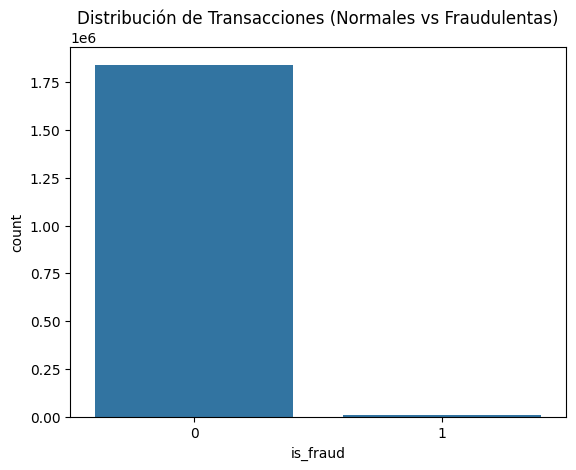

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Exploración inicial del dataset
df.head()
df.info()
df.describe()

# Verificar valores nulos
df.isnull().sum()

# Visualización de la distribución de las clases
sns.countplot(x='is_fraud', data=df)
plt.title('Distribución de Transacciones (Normales vs Fraudulentas)')
plt.show()

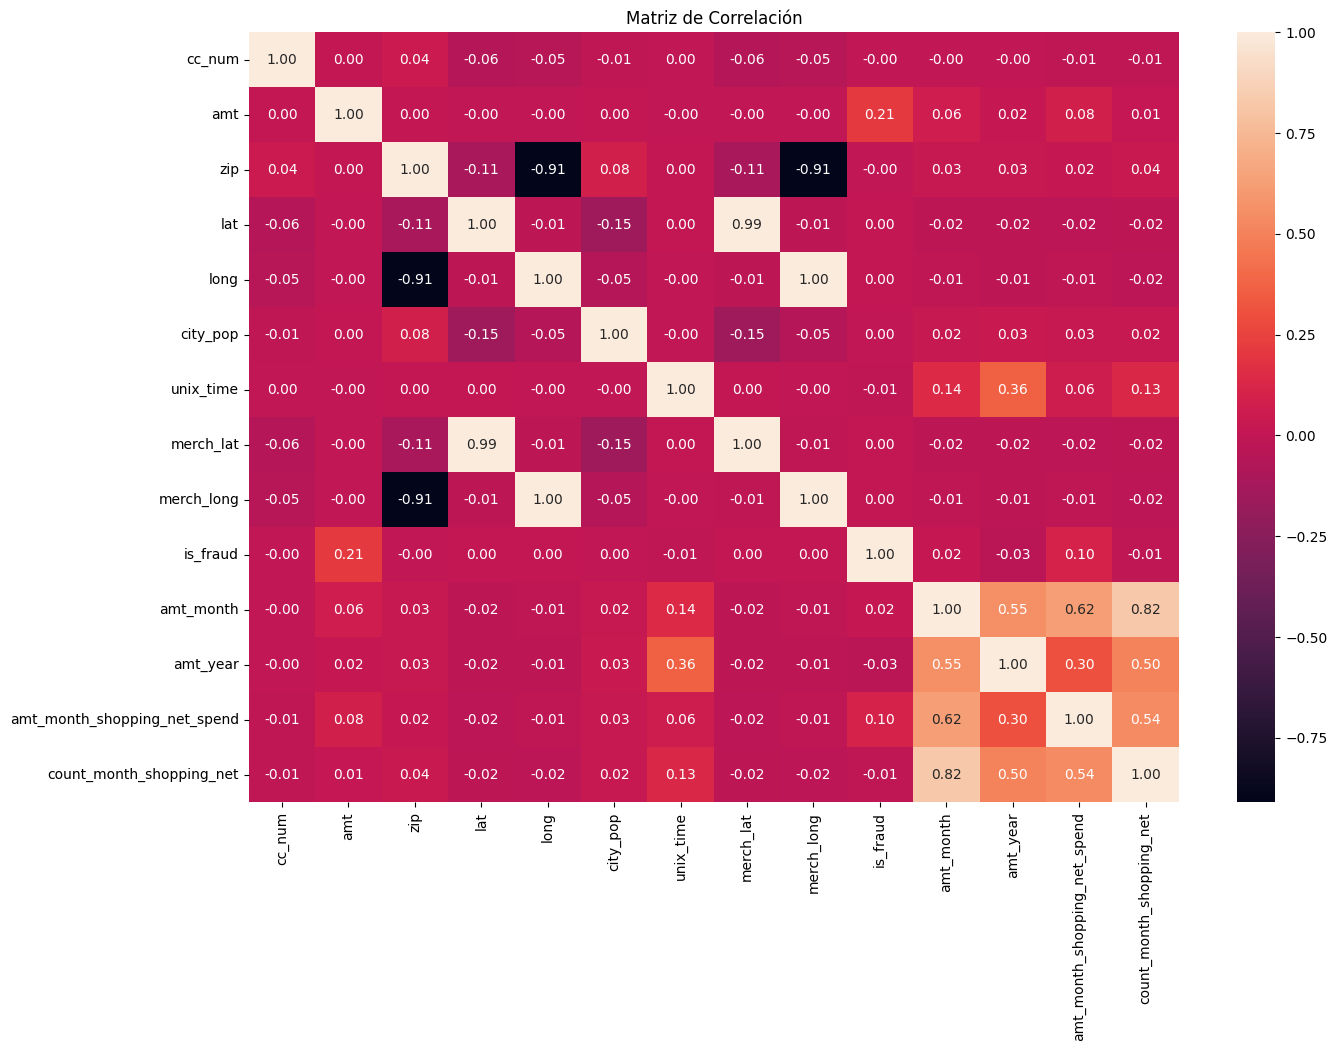

In [ ]:
# Matriz de correlación
numerical_columns = df.select_dtypes(include=[float, int]).columns
corr_matrix = df[numerical_columns].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

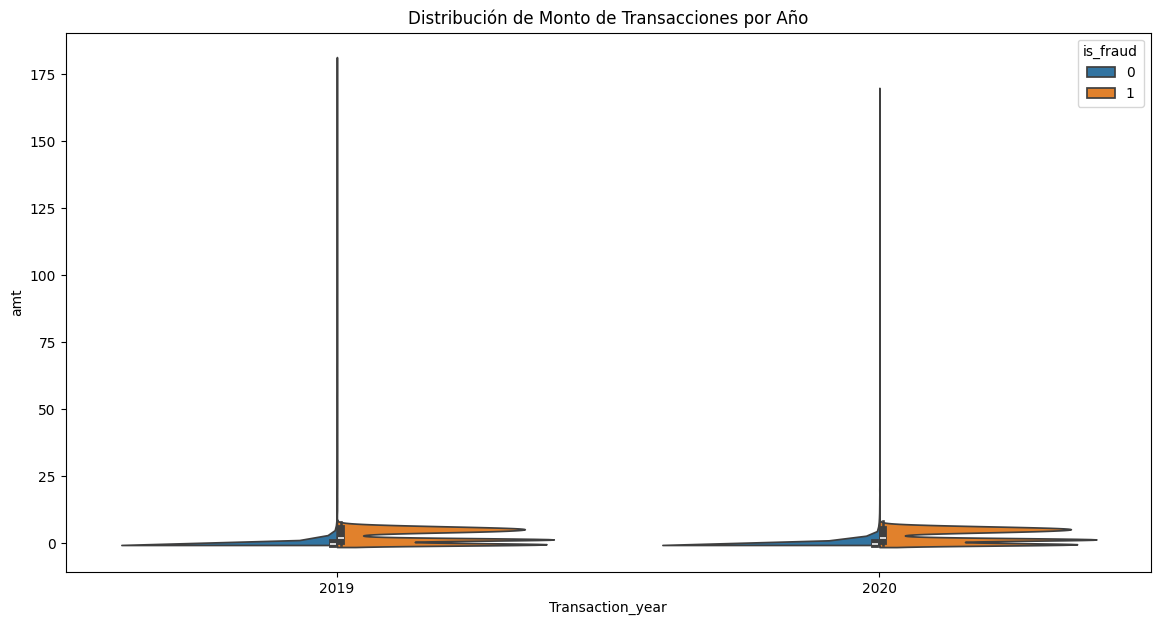

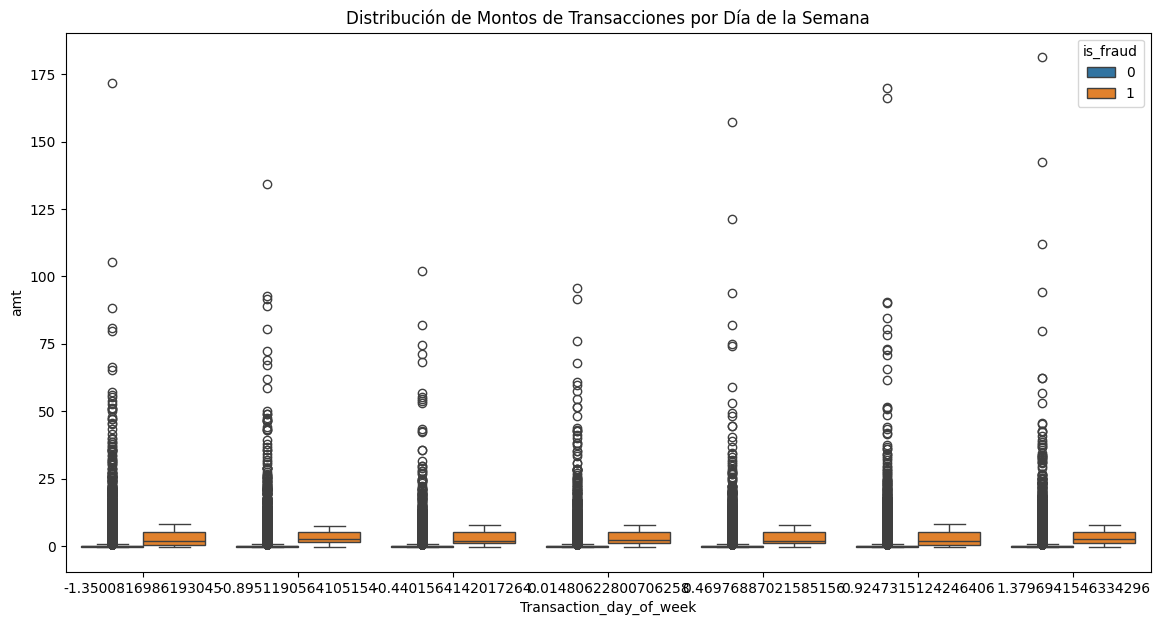

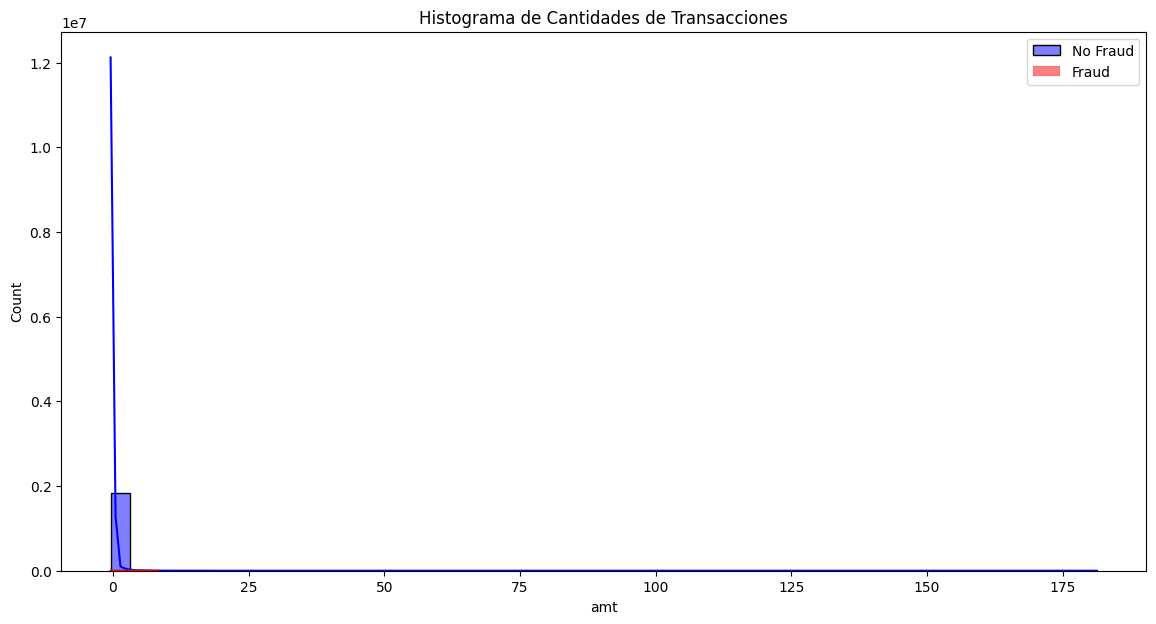

In [ ]:
# Gráfico de violín para mostrar la distribución de montos por año
plt.figure(figsize=(14, 7))
sns.violinplot(x='Transaction_year', y='amt', hue='is_fraud', data=df, split=True)
plt.title('Distribución de Monto de Transacciones por Año')
plt.show()

# Distribución de montos de transacciones por día de la semana
plt.figure(figsize=(14, 7))
sns.boxplot(x='Transaction_day_of_week', y='amt', hue='is_fraud', data=df)
plt.title('Distribución de Montos de Transacciones por Día de la Semana')
plt.show()

# Histograma de las cantidades de transacciones
plt.figure(figsize=(14, 7))
sns.histplot(df[df['is_fraud'] == 0]['amt'], bins=50, kde=True, color='blue', label='No Fraud')
sns.histplot(df[df['is_fraud'] == 1]['amt'], bins=50, kde=True, color='red', label='Fraud')
plt.title('Histograma de Cantidades de Transacciones')
plt.legend()
plt.show()

### Estandarizacion/Normalizacion de los Datos

In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Llenar valores nulos
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)  # Llenar con el valor más frecuente para categóricas
    else:
        df[column].fillna(df[column].median(), inplace=True)  # Llenar con la mediana para numéricas

# Eliminar variables no necesarias
df = df.drop(columns=['cc_num', 'trans_date_trans_time', 'merchant', 'category', 'gender', 'first', 'last', 'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num'])

# Seleccionar características a escalar (excluyendo la columna 'is_fraud' y 'year')
features_to_scale = df.columns.difference(['is_fraud', 'Transaction_year'])

# Inicializar el escalador
scaler = StandardScaler()

# Aplicar el escalador a las características seleccionadas
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Verificación de los datos normalizados/estandarizados
df[features_to_scale].head()

# Dividir el dataset en características (X) y la variable objetivo (y)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Asegurarse de que no hay NaNs
df = df.fillna(0)

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

### Preparando el Dataset de Entrenamiento

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en Train, Dev y Test
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convertir los datos a float (ya deberían estar limpios de NaNs)
X_train = X_train.astype(float)
X_dev = X_dev.astype(float)
X_test = X_test.astype(float)

y_train = y_train.astype(int)
y_dev = y_dev.astype(int)
y_test = y_test.astype(int)

print(f'Tamaño del conjunto de entrenamiento: {X_train.shape[0]}')
print(f'Tamaño del conjunto de validación: {X_dev.shape[0]}')
print(f'Tamaño del conjunto de prueba: {X_test.shape[0]}')

Tamaño del conjunto de entrenamiento: 2211291
Tamaño del conjunto de validación: 737097
Tamaño del conjunto de prueba: 737098


### Entrenamiento Normal de los Modelos

In [ ]:
!pip install xgboost

In [ ]:
!nvidia-smi

Fri May 24 05:57:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   64C    P8              14W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 481, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 481 (delta 143), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (481/481), 133.58 KiB | 759.00 KiB/s, done.
Resolving deltas: 100% (245/245), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.2 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a NVIDIA L4 GPU!
We will install the latest stable RAPIDS via pip 24.4.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 MB 6

Random Forest Metrics: {'ROC-AUC': 0.9999898572277597, 'Precision': 0.999409968540719, 'Recall': 0.9976711235607381, 'F1 Score': 0.9985397890504554, 'Accuracy': 0.998541577917726}


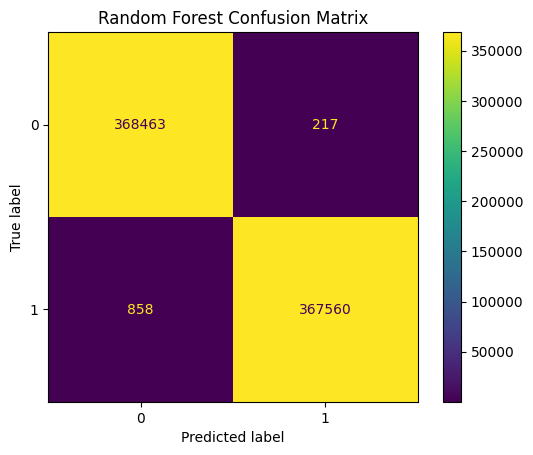

In [ ]:
import cuml
from cuml.ensemble import RandomForestClassifier as cuRF
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Inicializar el modelo Random Forest de cuML
rf_model = cuRF(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

# Entrenamiento del modelo
rf_model.fit(X_train, y_train)

# Predicción y evaluación del modelo Random Forest
y_pred_rf_proba = rf_model.predict_proba(X_test).to_numpy()[:, 1]
y_pred_rf = rf_model.predict(X_test)

rf_roc_auc = roc_auc_score(y_test, y_pred_rf_proba)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

rf_metrics = {
    'ROC-AUC': rf_roc_auc,
    'Precision': rf_precision,
    'Recall': rf_recall,
    'F1 Score': rf_f1,
    'Accuracy': rf_accuracy
}

print("Random Forest Metrics:", rf_metrics)

# Matriz de Confusión
rf_cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(rf_cm).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:23:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:23:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:23:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


XGBoost Metrics: {'ROC-AUC': 0.9999964878502449, 'Precision': 0.9993977848247201, 'Recall': 0.9999972856917957, 'F1 Score': 0.9996974453807507, 'Accuracy': 0.9996974622099096}


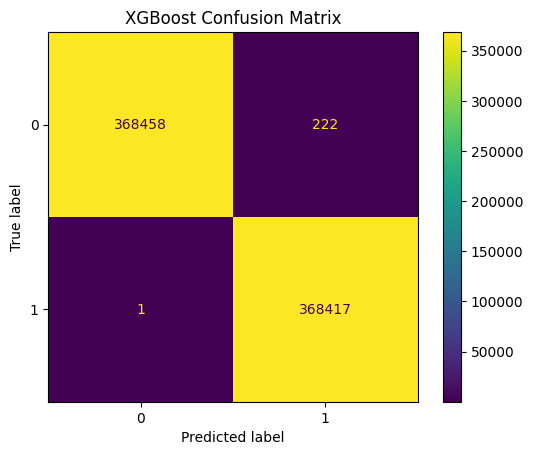

In [ ]:
import xgboost as xgb

# Inicializar el modelo XGBoost con GPU
params = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'alpha': 0.1,
    'lambda': 1,
    'random_state': 42
}
xgb_model = xgb.XGBClassifier(**params)

# Entrenamiento del modelo
xgb_model.fit(X_train, y_train)

# Predicción y evaluación del modelo XGBoost
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb_proba)
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

xgb_metrics = {
    'ROC-AUC': xgb_roc_auc,
    'Precision': xgb_precision,
    'Recall': xgb_recall,
    'F1 Score': xgb_f1,
    'Accuracy': xgb_accuracy
}

print("XGBoost Metrics:", xgb_metrics)

# Matriz de Confusión
xgb_cm = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(xgb_cm).plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

### Entrenamiento Incremental de los Modelos

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Incremental Random Forest Metrics: {'ROC-AUC': 0.9999877081329369, 'Precision': 0.9994958042739446, 'Recall': 0.9954345336004212, 'F1 Score': 0.9974610349784249, 'Accuracy': 0.9974670939278087}


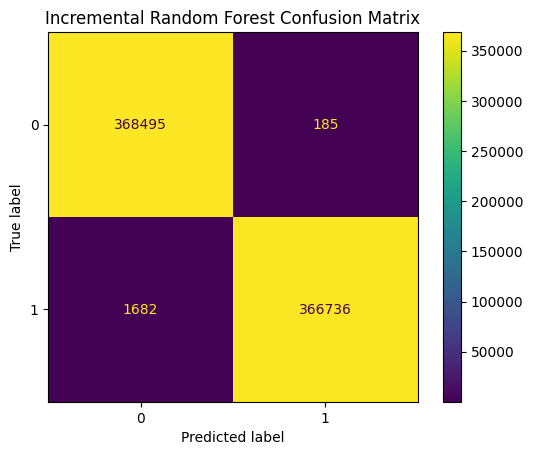

In [ ]:
# Inicializar el modelo Random Forest de cuML
rf_model = cuRF(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

# Entrenamiento incremental manual por año
years = sorted(X_train['Transaction_year'].unique())
for year in years:
    # Filtrar los datos por año
    X_train_year = X_train[X_train['Transaction_year'] == year]
    y_train_year = y_train.loc[X_train_year.index]

    # Entrenar el modelo con los datos del año actual
    rf_model.fit(X_train_year.drop(columns=['Transaction_year']), y_train_year)

# Predicción y evaluación del modelo Random Forest
y_pred_rf_proba = rf_model.predict_proba(X_test.drop(columns=['Transaction_year'])).to_numpy()[:, 1]
y_pred_rf = rf_model.predict(X_test.drop(columns=['Transaction_year']))

rf_roc_auc = roc_auc_score(y_test, y_pred_rf_proba)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

rf_metrics = {
    'ROC-AUC': rf_roc_auc,
    'Precision': rf_precision,
    'Recall': rf_recall,
    'F1 Score': rf_f1,
    'Accuracy': rf_accuracy
}

print("Incremental Random Forest Metrics:", rf_metrics)

# Matriz de Confusión
rf_cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(rf_cm).plot()
plt.title("Incremental Random Forest Confusion Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:47:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:47:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:47:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

XGBoost Metrics: {'ROC-AUC': 0.9999994098507341, 'Precision': 0.9998235939077478, 'Recall': 0.999959285376936, 'F1 Score': 0.9998914350387984, 'Accuracy': 0.9998914662636448}


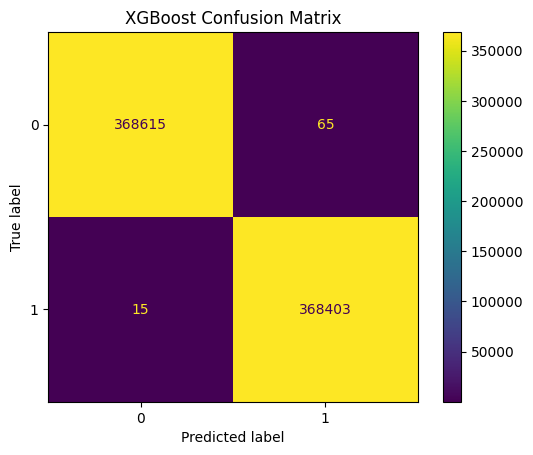

In [ ]:
# Inicializar los parámetros del modelo XGBoost
params = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'alpha': 0.1,
    'lambda': 1,
    'random_state': 42
}

# Inicializar el modelo XGBoost
xgb_model = None

# Entrenamiento incremental manual por año
years = sorted(X_train['Transaction_year'].unique())
for year in years:
    # Filtrar los datos por año
    X_train_year = X_train[X_train['Transaction_year'] == year]
    y_train_year = y_train.loc[X_train_year.index]

    dtrain = xgb.DMatrix(X_train_year.drop(columns=['Transaction_year']), label=y_train_year)

    # Entrenar el modelo con los datos del año actual
    if xgb_model is None:
        xgb_model = xgb.train(params, dtrain, num_boost_round=100)
    else:
        xgb_model = xgb.train(params, dtrain, num_boost_round=100, xgb_model=xgb_model)

# Predicción y evaluación del modelo XGBoost
dtest = xgb.DMatrix(X_test.drop(columns=['Transaction_year']))
y_pred_xgb_proba = xgb_model.predict(dtest)
y_pred_xgb = (y_pred_xgb_proba > 0.5).astype(int)

xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb_proba)
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

xgb_metrics = {
    'ROC-AUC': xgb_roc_auc,
    'Precision': xgb_precision,
    'Recall': xgb_recall,
    'F1 Score': xgb_f1,
    'Accuracy': xgb_accuracy
}

print("XGBoost Metrics:", xgb_metrics)

# Matriz de Confusión
xgb_cm = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(xgb_cm).plot()
plt.title("XGBoost Confusion Matrix")
plt.show()